In [23]:
import numpy as np
import matplotlib.pyplot as plt

import cv2

In [24]:
plt.rcParams['figure.dpi'] = 150

In [25]:
def blank_image(shape=(600, 800, 4),
               rgba=(255, 255, 255, 0)):
    "Returns a blank image, of size defined by shape and background color rgb."
    return np.ones(shape, dtype=float) * np.array(rgba) / 255.

In [26]:
img = blank_image()

In [27]:
def display(img, colorbar=False):
    "Displays an image."
    plt.figure(figsize=(10, 10))
    if len(img.shape) == 2:
        i = plt.imshow(img, cmap='gray')
    else:
        i = plt.imshow(img)
    if colorbar:
        plt.colorbar(i, shrink=0.5, label='depth')
    plt.tight_layout()
    plt.axis('off')

(250, 400)


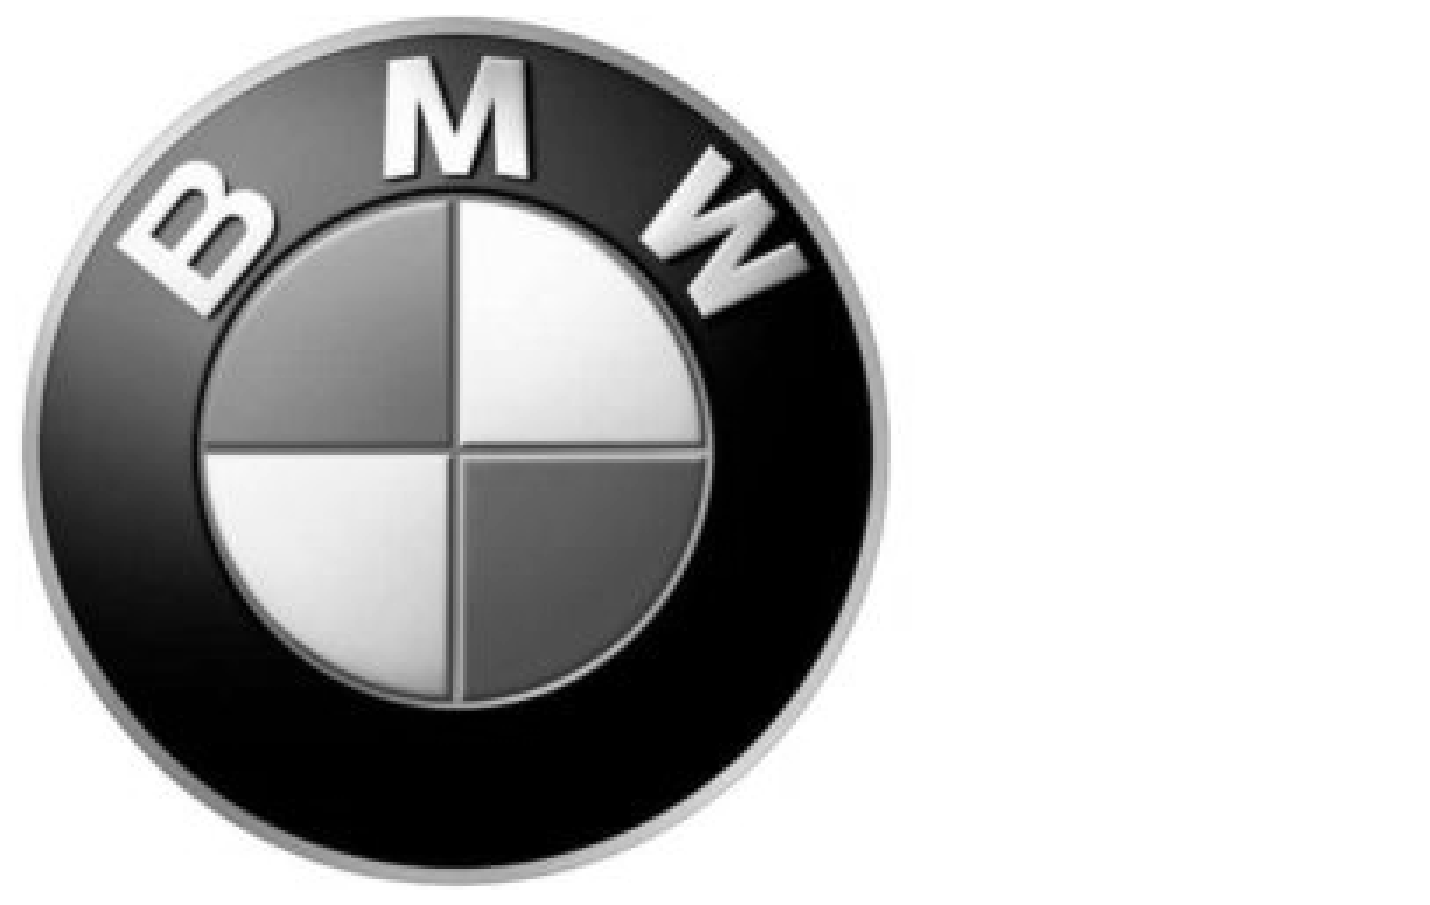

In [28]:
apple = cv2.imread('bmv.jpg')
apple = cv2.cvtColor(apple,cv2.COLOR_BGR2GRAY)
# nike.resize((120, 120))
# nike = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
display(apple)
print(apple.shape)

In [29]:
def make_pattern(shape=(16, 16), levels=64):
    "Creates a pattern from gray values."
    return np.random.randint(0, levels - 1, shape) / levels

In [30]:
pattern = make_pattern(shape=(128, 64))

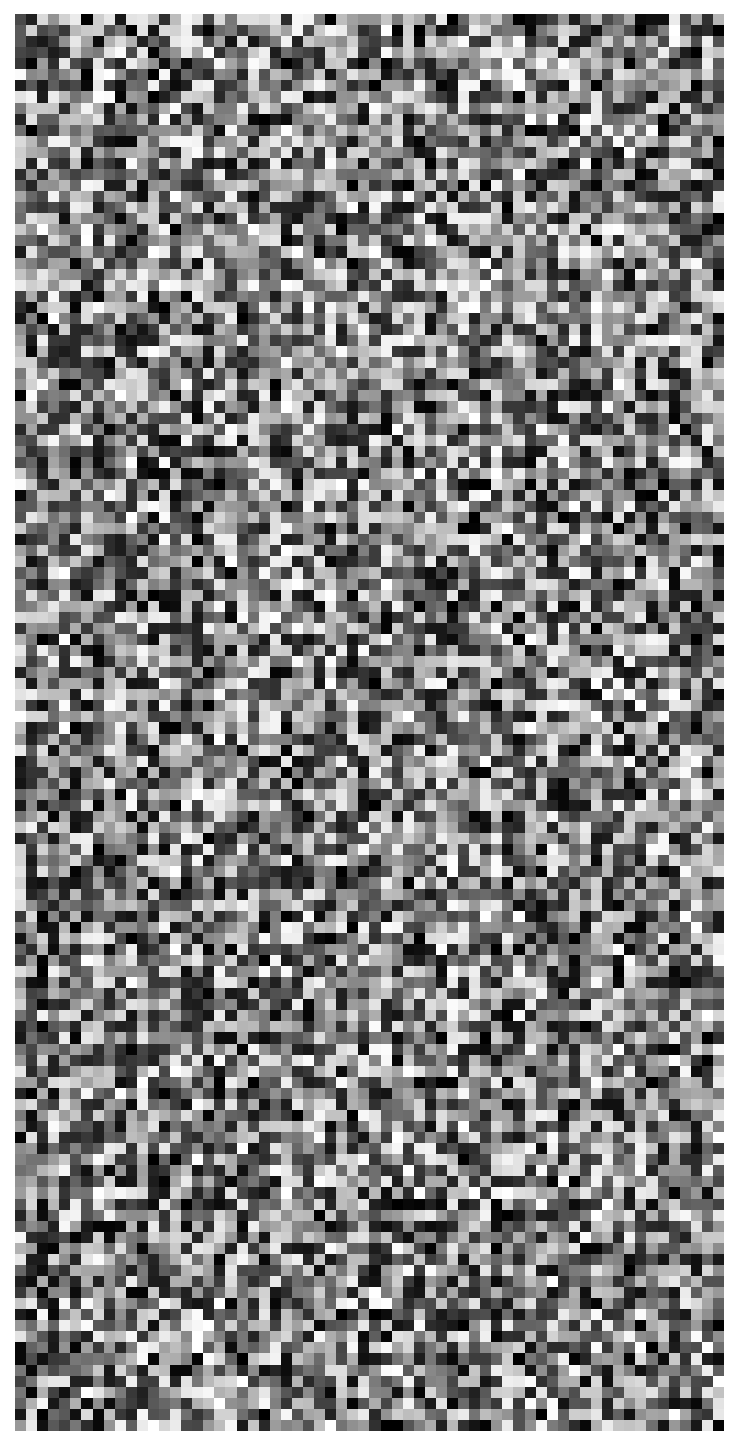

In [31]:
display(pattern)

In [32]:
def create_circular_depthmap(shape=(600, 800), center=None, radius=100):
    "Creates a circular depthmap, centered on the image."
    depthmap = np.zeros(shape, dtype=float)
    r = np.arange(depthmap.shape[0])
    c = np.arange(depthmap.shape[1])
    R, C = np.meshgrid(r, c, indexing='ij')
    if center is None:
        center = np.array([r.max() / 2, c.max() / 2])
    d = np.sqrt((R - center[0])**2 + (C - center[1])**2)
    depthmap += (d < radius)
    return depthmap   

In [33]:
depthmap = create_circular_depthmap(radius=150)

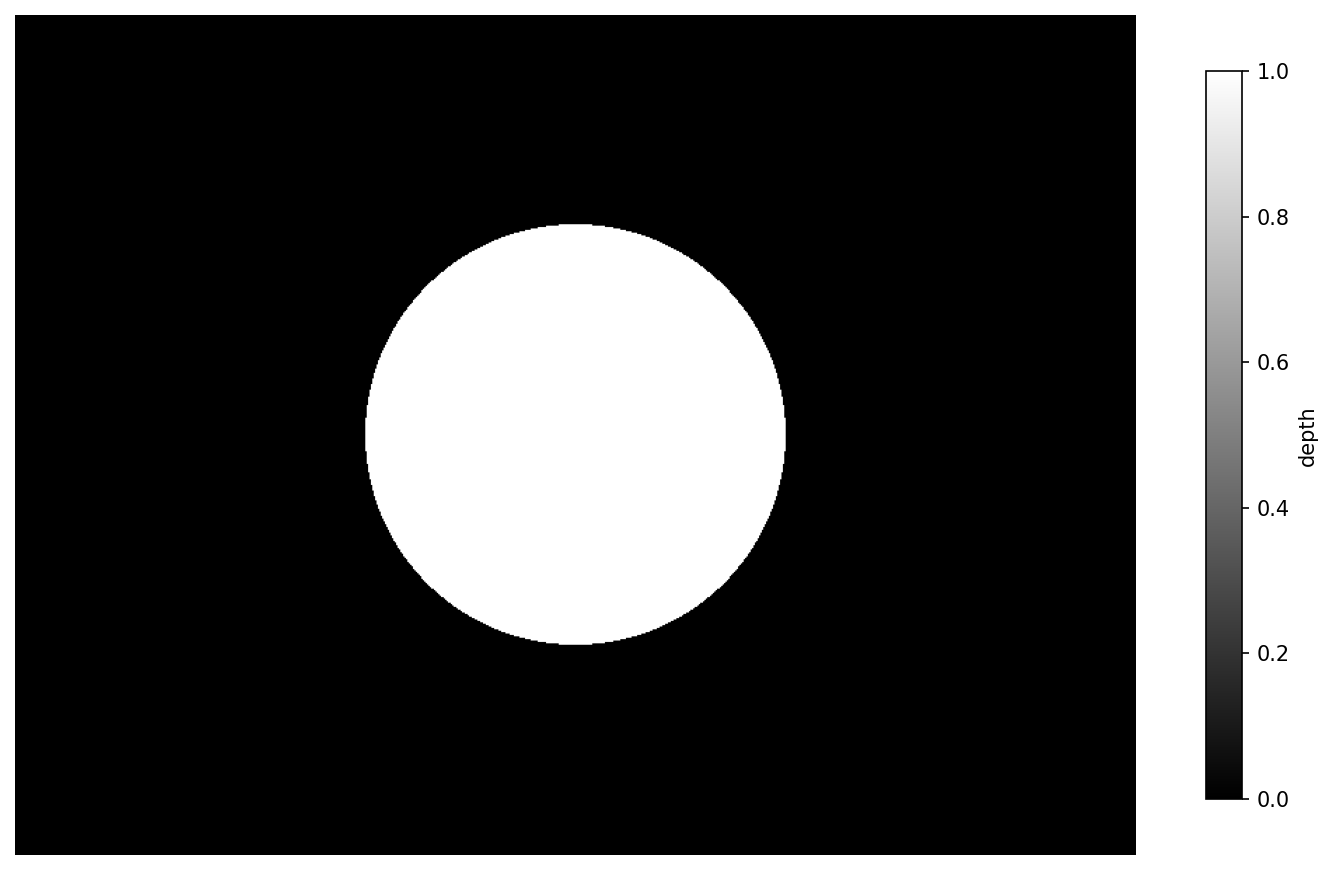

In [34]:
display(depthmap, colorbar=True)

In [35]:
def normalize(depthmap):
    "Normalizes values of depthmap to [0, 1] range."
    if depthmap.max() > depthmap.min():
        return (depthmap - depthmap.min()) / (depthmap.max() - depthmap.min())
    else:
        return depthmap

In [36]:
def make_autostereogram(depthmap, pattern, shift_amplitude=0.1, invert=False):
    "Creates an autostereogram from depthmap and pattern."
    depthmap = normalize(depthmap)
    if invert:
        depthmap = 1 - depthmap
    autostereogram = np.zeros_like(depthmap, dtype=pattern.dtype)
    for r in np.arange(autostereogram.shape[0]):
        for c in np.arange(autostereogram.shape[1]):
            if c < pattern.shape[1]:
                autostereogram[r, c] = pattern[r % pattern.shape[0], c]
            else:
                shift = int(depthmap[r, c] * shift_amplitude * pattern.shape[1])
                autostereogram[r, c] = autostereogram[r, c - pattern.shape[1] + shift]
    return autostereogram

In [37]:
A = make_autostereogram(depthmap, pattern)

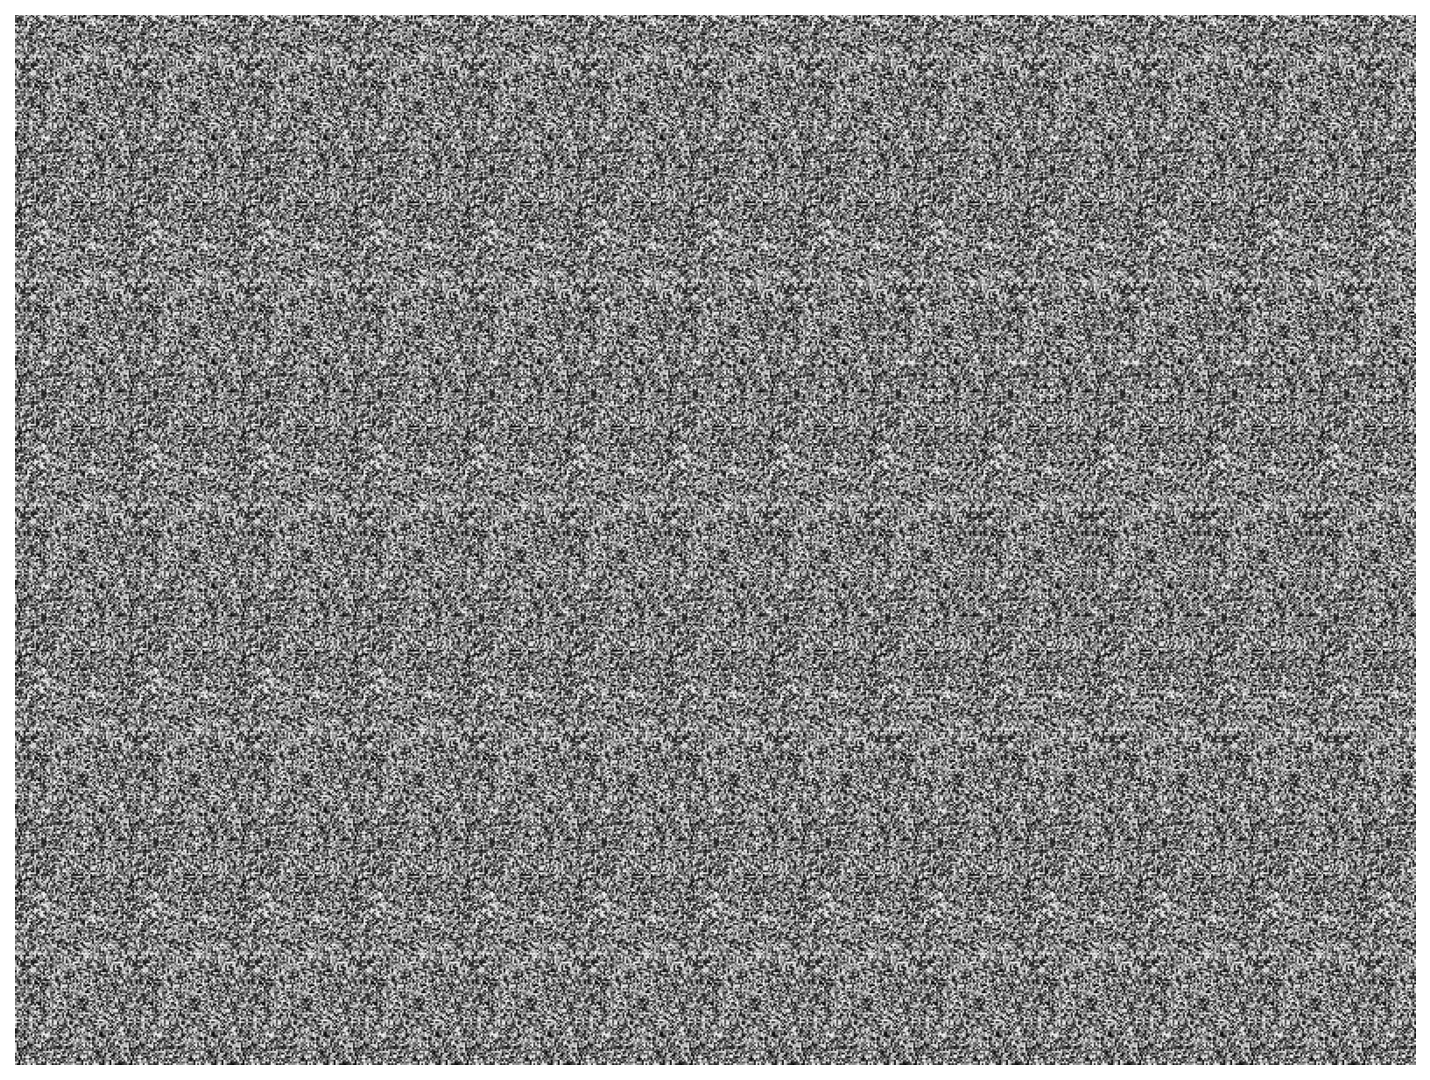

In [38]:
display(A)

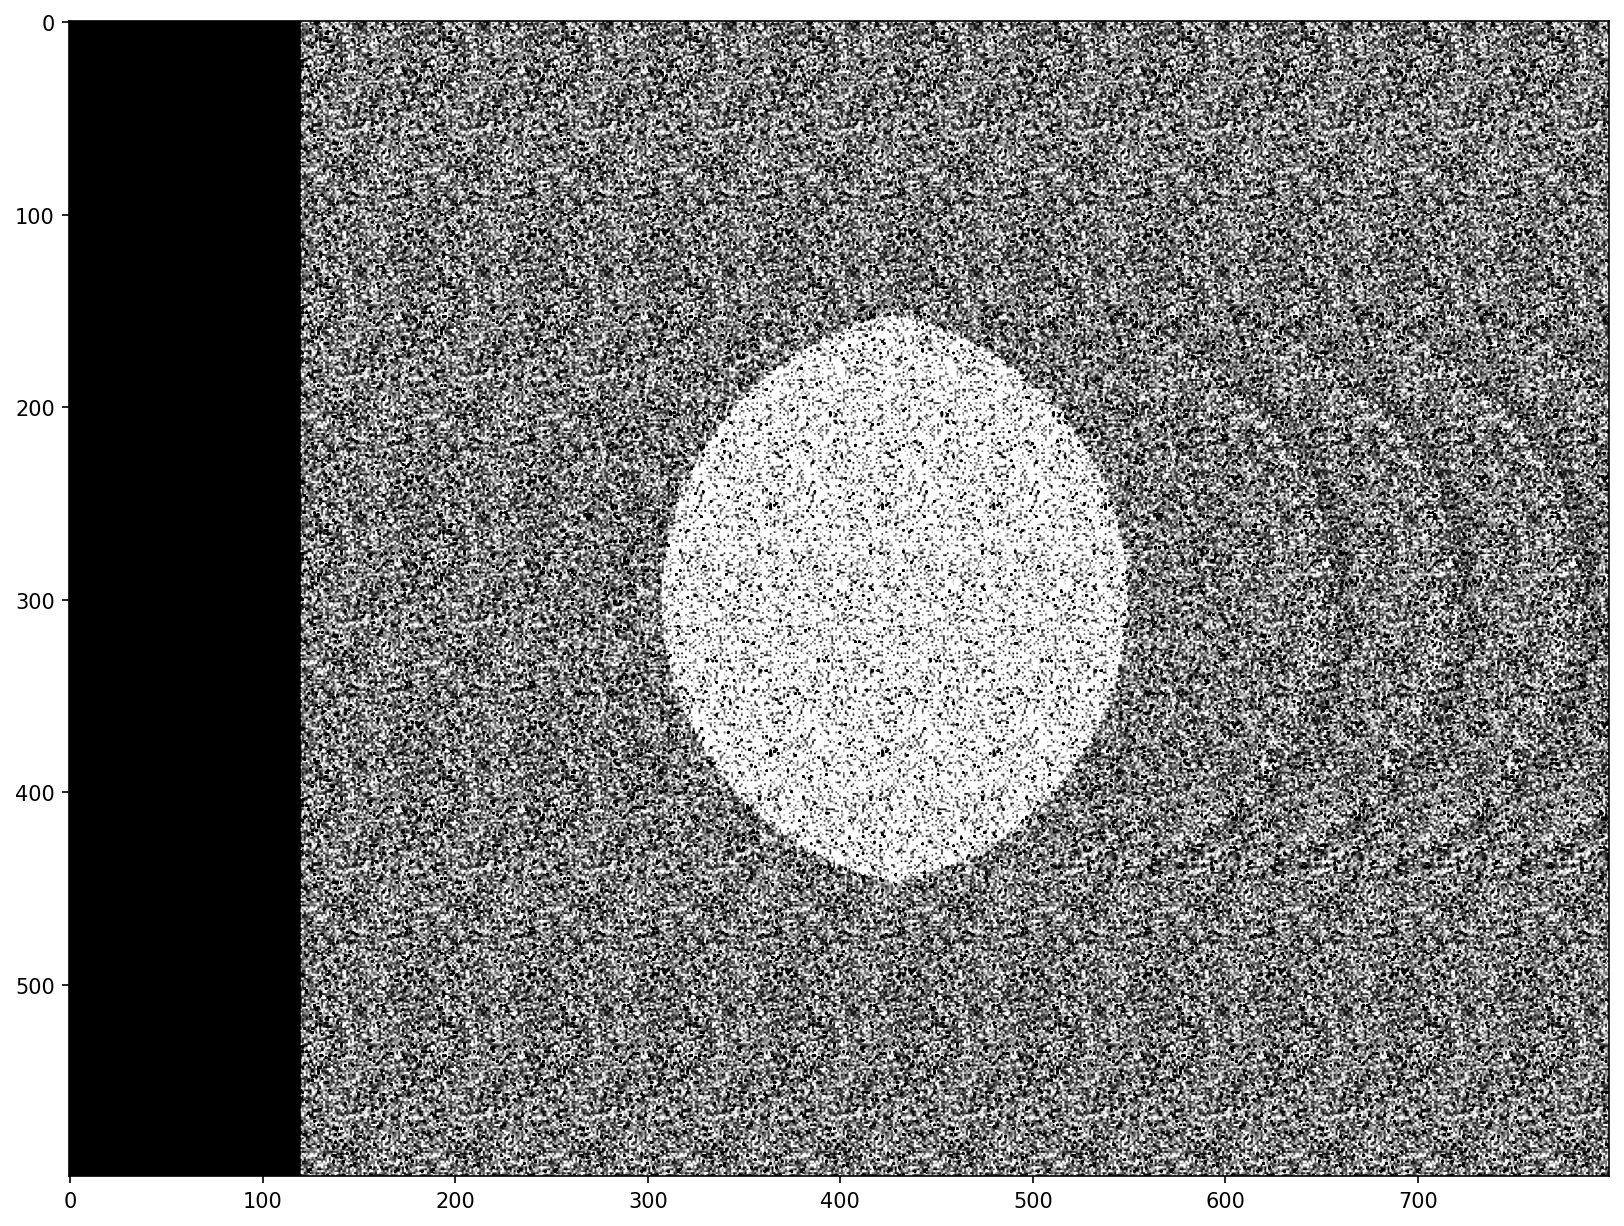

In [39]:
# The Z-depth (starting with 0)
Z = np.zeros(A.shape)

# Image difference at 120 pixels
Sm = np.pad(np.abs(A[:,120:]-A[:,:-120]),((0,0),(120,0)),'constant',constant_values=0)

## Sweeping Image at depth =s
Ss = np.arange(90,120)
for s in Ss:
    S = np.pad(np.abs(A[:,s:]-A[:,:-s]),((0,0),(int(s),0)),'constant',constant_values=0)
    Z[S<Sm] = s
    Sm = np.minimum(S,Sm)
    
fig, ax = plt.subplots(1,1,figsize=(10*A.shape[1]/A.shape[0],10))
ax.imshow(Z,cmap='gray',vmin=90,vmax=113);   